In [66]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Dense, Dropout, Activation, LSTM, Convolution1D, MaxPooling1D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
## Data preparation
%ls

 Archive.zip             'SP500 05-16.csv'
'CBOE yearly 04-18.csv'   stock_conv1d-Copy1.ipynb
'^DJI.csv'                stock_conv1d.ipynb
'EUR_GBP 05-16.csv'       stock_conv1d-out-of-sample.ipynb
'EUR_JPY 05-16.csv'       stock_dilatedconv+lstm.ipynb
'EUR_USD 05-16.csv'       stock_lstm+conv1d.ipynb
'GBP_JPY 05-16.csv'       stock_nn.ipynb
'GBP_USD 05-16.csv'       stock_rnn_lstm.ipynb
'^GSPC.csv'              'Volatility 05-16.csv'
 README.md


In [68]:
data= pd.read_csv('^DJI.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [69]:
data= data.dropna(axis=0)#drop rows which may contain missing values
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [70]:
data= data.values[:, 1:5]
print (data.shape)

(4284, 4)


In [71]:
print (data[:6, :])

[[11501.849609 11522.009766 11305.69043 11357.509766]
 [11349.75 11350.05957 10986.450195 10997.929688]
 [10989.370117 11215.099609 10938.669922 11122.650391]
 [11113.370117 11313.450195 11098.450195 11253.259766]
 [11247.05957 11528.139648 11239.919922 11522.55957]
 [11532.480469 11638.280273 11532.480469 11572.200195]]


In [72]:
y= data[1:, 3] #the close price
print (y.shape)
X= data[:4283,:]
print (X.shape)

(4283,)
(4283, 4)


In [73]:
# y= (y- min(y))/(max(y)- min(y)) #??? normalsation
print (y[4270:])
print (y[:7])

[19918.880859 19933.810547 19945.039063 19833.679688 19819.779297
 19762.599609 19881.759766 19942.160156 19899.289063 19963.800781
 19887.380859 19855.529297 19954.279297]
[10997.929688 11122.650391 11253.259766 11522.55957 11572.200195
 11511.080078 11551.099609]


In [74]:
# X= (X- np.min(X,axis=0))/(np.max(X, axis=0)-np.min(X,axis=0))
print (X.shape)
print (X[:3, :])

(4283, 4)
[[11501.849609 11522.009766 11305.69043 11357.509766]
 [11349.75 11350.05957 10986.450195 10997.929688]
 [10989.370117 11215.099609 10938.669922 11122.650391]]


In [75]:
## Sequence data preparation
"""
Rowling the window size = 100 days
This example is in sample forcasting
what is different of in sample and out of sample forecasting: 

https://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts
"""

'\nRowling the window size = 100 days\nThis example is in sample forcasting\nwhat is different of in sample and out of sample forecasting: \n\nhttps://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts\n'

In [76]:
time_steps= 100 #1 to 100 days ahead
X_new= np.zeros((X.shape[0] - time_steps +1, 100, X.shape[1]))
y_new= np.zeros((y.shape[0] -time_steps +1,))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :]= X[ix +jx, :]
    y_new[ix]= y[ix + time_steps -1]
print (X_new.shape, y_new.shape)

(4184, 100, 4) (4184,)


In [77]:
## split into train and test sets

In [78]:
split = int(0.8*data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(3427, 100, 4) (3427,)
(757, 100, 4) (757,)


In [79]:
# data normalisation after split the train/test

y_train= (y_train- min(y_train))/(max(y_train)- min(y_train))
X_train= (X_train- np.min(X_train,axis=0))/(np.max(X_train, axis=0)-np.min(X_train,axis=0))

y_test= (y_test- min(y_test))/(max(y_test)- min(y_test))
X_test= (X_test- np.min(X_test,axis=0))/(np.max(X_test, axis=0)-np.min(X_test,axis=0))

In [80]:
## Model fitting

In [81]:
model = Sequential()
model.add(Convolution1D(64, 3, input_shape= (100,4), border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Convolution1D(32, 3, border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

model.summary()

# from torchsummary import summary

# class model(nn.Module):
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
#         super().__init__()
        
#         self.conv1 = nn.Conv1d(64, 3, (100,4), padding=0)
#         self.conv2 = nn.Conv1d(32,3,padding=0)
#         self.fc1 = nn.Linear(16, 1)
        
        
#     def forward(self,x):
#         out = self.conv1(x)
# #         out = F.relu(out)
#         out = F.max_pool1d(out, 2)
#         out = self.conv2(x)
# #         out = F.relu(out)
#         out = F.max_pool1d(out, 2)
#         out = out.view(out.shape[0], -1)
#         out = self.fc1(out)
#         out = F.relu(out)
#         return out
# summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 100, 64)           832       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 50, 32)            6176      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 801       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total para

/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, input_shape=(100, 4), padding="same")`
  
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, padding="same")`
  after removing the cwd from sys.path.
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  """
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  import sys


In [82]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [83]:
model.fit(X_train, y_train, batch_size=256, nb_epoch=50,  verbose=2)

/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/50
 - 0s - loss: 0.0990 - acc: 2.9180e-04
Epoch 2/50
 - 0s - loss: 0.0160 - acc: 5.8360e-04
Epoch 3/50
 - 0s - loss: 0.0056 - acc: 5.8360e-04
Epoch 4/50
 - 0s - loss: 0.0038 - acc: 5.8360e-04
Epoch 5/50
 - 0s - loss: 0.0027 - acc: 5.8360e-04
Epoch 6/50
 - 0s - loss: 0.0023 - acc: 5.8360e-04
Epoch 7/50
 - 0s - loss: 0.0019 - acc: 5.8360e-04
Epoch 8/50
 - 0s - loss: 0.0017 - acc: 5.8360e-04
Epoch 9/50
 - 0s - loss: 0.0015 - acc: 5.8360e-04
Epoch 10/50
 - 0s - loss: 0.0014 - acc: 5.8360e-04
Epoch 11/50
 - 0s - loss: 0.0013 - acc: 5.8360e-04
Epoch 12/50
 - 0s - loss: 0.0012 - acc: 5.8360e-04
Epoch 13/50
 - 0s - loss: 0.0011 - acc: 5.8360e-04
Epoch 14/50
 - 0s - loss: 0.0010 - acc: 5.8360e-04
Epoch 15/50
 - 0s - loss: 9.8329e-04 - acc: 5.8360e-04
Epoch 16/50
 - 0s - loss: 9.3737e-04 - acc: 5.8360e-04
Epoch 17/50
 - 0s - loss: 8.8256e-04 - acc: 5.8360e-04
Epoch 18/50
 - 0s - loss: 8.3064e-04 - acc: 5.8360e-04
Epoch 19/50
 - 0s - loss: 8.0295e-04 - acc: 5.8360e-04
Epoch 20/50
 - 0s - 

In [84]:
score= model.evaluate(X_test, y_test, batch_size=256)

757/757 [==============================] - 0s 68us/step


In [85]:
print (score)

[0.0027701540129158346, 0.0026420078688157204]


In [86]:
y_pred= model.predict(X_test)
y_pred.shape

(757, 1)

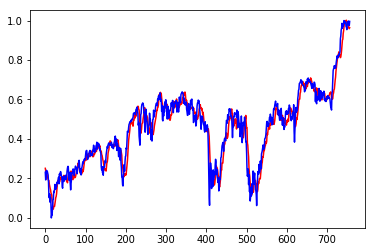

In [87]:
plt.plot(range(len(y_pred)), y_pred, 'r-')
plt.plot(range(len(y_test)), y_test, 'b-')
plt.show()

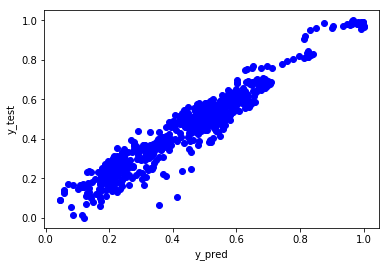

In [88]:
plt.plot (y_pred, y_test, 'bo')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [89]:
%ls

 Archive.zip             'SP500 05-16.csv'
'CBOE yearly 04-18.csv'   stock_conv1d-Copy1.ipynb
'^DJI.csv'                stock_conv1d.ipynb
'EUR_GBP 05-16.csv'       stock_conv1d-out-of-sample.ipynb
'EUR_JPY 05-16.csv'       stock_dilatedconv+lstm.ipynb
'EUR_USD 05-16.csv'       stock_lstm+conv1d.ipynb
'GBP_JPY 05-16.csv'       stock_nn.ipynb
'GBP_USD 05-16.csv'       stock_rnn_lstm.ipynb
'^GSPC.csv'              'Volatility 05-16.csv'
 README.md


In [90]:
data= pd.read_csv('^GSPC.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2019-06-19,2920.550049,2931.739990,2911.429932,2926.459961,2926.459961,3287890000
1255,2019-06-20,2949.600098,2958.060059,2931.500000,2954.179932,2954.179932,3905940000
1256,2019-06-21,2952.709961,2964.149902,2946.870117,2950.459961,2950.459961,5000120000
1257,2019-06-24,2951.419922,2954.919922,2944.050049,2945.350098,2945.350098,3136250000
1258,2019-06-25,2945.780029,2946.520020,2916.010010,2917.379883,2917.379883,2020032887


In [91]:
data= data.values[:, 1:5]
print (data.shape)

(1259, 4)


In [92]:
y= data[1:, 3] #the close price
print (y.shape)
X= data[:1258,:]
print (X.shape)

(1258,)
(1258, 4)


In [93]:
# data normalisation after split the train/test

y= (y- min(y))/(max(y)- min(y))
X= (X- np.min(X,axis=0))/(np.max(X, axis=0)-np.min(X,axis=0))
print (X.shape, y.shape)

(1258, 4) (1258,)


In [94]:
time_steps= 100 #1 to 100 days ahead
X_new= np.zeros((X.shape[0] - time_steps +1, 100, X.shape[1]))
y_new= np.zeros((y.shape[0] -time_steps +1,))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :]= X[ix +jx, :]
    y_new[ix]= y[ix + time_steps -1]
print (X_new.shape, y_new.shape)

(1159, 100, 4) (1159,)


In [95]:
y_pred= model.predict(X_new)
y_pred.shape

(1159, 1)

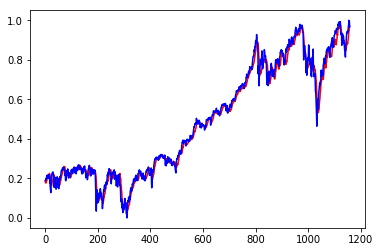

In [96]:
plt.plot(range(len(y_pred)), y_pred, 'r-')
plt.plot(range(len(y_new)), y_new, 'b-')
plt.show()

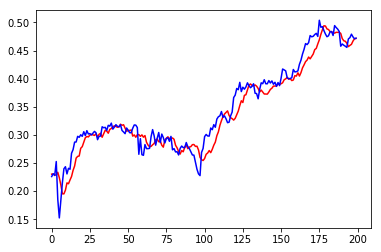

In [100]:
plt.plot(y_pred[400:600], 'r-')
plt.plot(y_new[400:600], 'b-')
plt.show()

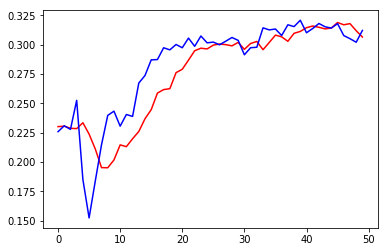

In [101]:
plt.plot(y_pred[400:450], 'r-')
plt.plot(y_new[400:450], 'b-')
plt.show()